In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
# Load data
paths = [
    'trades_round_5_day_2.csv',
    'trades_round_5_day_3.csv',
    'trades_round_5_day_4.csv'
]
dfs = [pd.read_csv(p, sep=';') for p in paths]
trades = pd.concat(dfs)
trades.columns = ['timestamp', 'buyer', 'seller', 'product', 'currency', 'price', 'quantity']
trades['timestamp'] = trades['timestamp'].astype(int)
trades['price'] = trades['price'].astype(float)
trades['quantity'] = trades['quantity'].astype(int)

In [25]:
# Filter basket trades
basket_trades = trades[trades['product'].str.contains('PICNIC_BASKET2')]
basket_trades = basket_trades.sort_values('timestamp')
basket_trades.head()

,timestamp,buyer,seller,product,currency,price,quantity
12,1000,Camilla,Pablo,PICNIC_BASKET2,SEASHELLS,30064.0,7
20,1300,Pablo,Camilla,PICNIC_BASKET2,SEASHELLS,30114.0,6
40,1500,Penelope,Charlie,PICNIC_BASKET2,SEASHELLS,30134.0,5
46,1700,Penelope,Camilla,PICNIC_BASKET2,SEASHELLS,30134.0,6
38,2100,Charlie,Penelope,PICNIC_BASKET2,SEASHELLS,30051.0,9


In [26]:
# Signal strength analysis: buyer-seller pair impact on price movement
WINDOW = 200  # time window to assess price movement
results = []
pairs = basket_trades[['seller', 'buyer']].drop_duplicates()
for _, row in pairs.iterrows():
    seller, buyer = row['seller'], row['buyer']
    pair_trades = basket_trades[(basket_trades['seller'] == seller) & (basket_trades['buyer'] == buyer)]
    deltas = []
    for _, trade in pair_trades.iterrows():
        p0 = trade['price']
        t0 = trade['timestamp']
        prod = trade['product']
        after = basket_trades[(basket_trades['timestamp'] > t0) & (basket_trades['timestamp'] <= t0 + WINDOW) & (basket_trades['product'] == prod)]
        if not after.empty:
            p1 = after['price'].mean()
            deltas.append(p1 - p0)
    if deltas:
        results.append({'seller': seller, 'buyer': buyer, 'count': len(deltas), 'avg_delta': np.mean(deltas)})
signals_df = pd.DataFrame(results).sort_values('avg_delta', ascending=False)
signals_df

,seller,buyer,count,avg_delta
12,Penelope,Pablo,3,50.333333
7,Penelope,Camilla,40,19.420833
2,Charlie,Penelope,27,0.808642
6,Pablo,Charlie,44,-0.715909
4,Penelope,Charlie,18,-3.509259
10,Caesar,Pablo,22,-5.454545
11,Caesar,Camilla,17,-6.500000
0,Pablo,Camilla,67,-6.835821
9,Penelope,Caesar,39,-7.739316
8,Caesar,Penelope,31,-7.887097


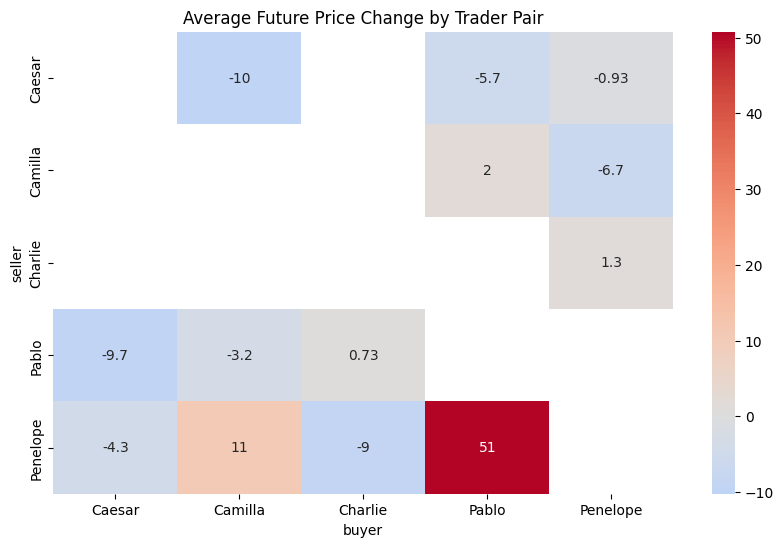

In [14]:
# Heatmap of signal strengths
pivot = signals_df.pivot(index='seller', columns='buyer', values='avg_delta')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', center=0)
plt.title('Average Future Price Change by Trader Pair')
plt.show()